# **Chatbot using Seq2Seq LSTM models**

This approach centers to creating the chat bot using an LSTM without LLMs

# Step 1: Import all the packages 

In [44]:
import numpy as np 
import tensorflow as tf
import pickle
from tensorflow.keras import layers, activations, models, preprocessing
import pandas as pd

# Step 2: Loading and Preprocessing the Data


In [45]:
import pandas as pd

def load_csv(file_path):
    """
    Load a CSV file and preprocess the data by converting all text data to lowercase.

    Parameters:
    - file_path (str): Path to the CSV file.

    Returns:
    - pd.DataFrame: Preprocessed DataFrame with all text data converted to lowercase.
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)

    # Convert all string data to lowercase
    df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)

    return df

# Example usage
file_path = "/kaggle/input/nutriton/food_data_qa_pairs.csv"  # Replace with the actual path
df = load_csv(file_path)

# Display the first few rows
df.head()


/tmp/ipykernel_24/726549551.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


,Question,Answer
0,what is the caloric value of cream cheese?,the caloric value of cream cheese is 51.
1,what is the fat of cream cheese?,the fat of cream cheese is 5.0.
2,what is the carbohydrates of cream cheese?,the carbohydrates of cream cheese is 0.8.
3,what is the sugars of cream cheese?,the sugars of cream cheese is 0.5.
4,what is the calcium of cream cheese?,the calcium of cream cheese is 0.008.


In [46]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer


# Initialize lists for questions and answers
questions = df['Question'].tolist()  # Assuming column name is 'Question'
answers = df['Answer'].tolist()      # Assuming column name is 'Answer'

# Add <START> and <END> tags to answers
answers_with_tags = [f"<START> {answer} <END>" for answer in answers]

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers_with_tags)

# Compute vocabulary size
VOCAB_SIZE = len(tokenizer.word_index) + 1

print(f"VOCAB SIZE: {VOCAB_SIZE}")
print(questions[0])
print(answers[0])


VOCAB SIZE: 1244
what is the caloric value of cream cheese?
the caloric value of cream cheese is 51.


### b) Preparing data for Seq2Seq model

This model requires 3 arrays encoder_input_data, decoder_input_data and decoder_output_data.

For encoder_input_data:
Tokensize the Questions and Pad them to their maximum Length.

For decoder_input_data:
Tokensize the Answers and Pad them to their maximum Length.

For decoder_output_data:
Tokensize the Answers and Remove the 1st element from all the tokenized_answers. This is the <START> element which was added earlier.

In [47]:
from gensim.models import Word2Vec
import re

In [48]:
vocab = []
for word in tokenizer.word_index:
  vocab.append(word)

def tokenize(sentences):
  tokens_list = []
  vocabulary = []
  for sentence in sentences:
    sentence = sentence.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    tokens = sentence.split()
    vocabulary += tokens
    tokens_list.append(tokens)
  return tokens_list, vocabulary

In [49]:
#encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions, maxlen = maxlen_questions, padding = 'post')
encoder_input_data = np.array(padded_questions)
print(encoder_input_data.shape, maxlen_questions)

(4408, 14) 14


In [50]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

print(maxlen_answers)

(4408, 15) 15
15


In [10]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=e31f352b89bc66cf84866b788daf09ce90d28ddfe66dbe4b33196ab9cff61b16
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [51]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure tokenizer and answers are already defined
tokenized_answers = tokenizer.texts_to_sequences(answers)

# Remove the <START> token from answers to prepare for decoder outputs
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]

# Pad the tokenized sequences
padded_answers = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post')

# Convert padded answers to one-hot encoding
onehot_answers = to_categorical(padded_answers, num_classes=VOCAB_SIZE)

# Convert to numpy array
decoder_output_data = np.array(onehot_answers)

# Print the shape of the output
print(decoder_output_data.shape)


(4408, 15, 1244)


# Step 4: Defining Encoder Decoder Model





In [62]:
import tensorflow as tf

def create_seq2seq_model(vocab_size, maxlen_questions, maxlen_answers, embedding_dim=200, lstm_units=200):
    """
    Creates a Seq2Seq model with an encoder-decoder architecture using LSTM layers.

    Parameters:
        vocab_size (int): The size of the vocabulary.
        maxlen_questions (int): The maximum length of input questions.
        maxlen_answers (int): The maximum length of output answers.
        embedding_dim (int): The dimension of the word embeddings. Default is 200.
        lstm_units (int): The number of LSTM units in the encoder and decoder. Default is 200.

    Returns:
        tf.keras.Model: The compiled Seq2Seq model.
    """
    # Encoder
    encoder_inputs = tf.keras.layers.Input(shape=(maxlen_questions,))
    encoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
    encoder_outputs, state_h, state_c = tf.keras.layers.LSTM(lstm_units, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = tf.keras.layers.Input(shape=(maxlen_answers,))
    decoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(decoder_inputs)
    decoder_lstm = tf.keras.layers.LSTM(lstm_units, return_state=True, return_sequences=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
    decoder_dense = tf.keras.layers.Dense(vocab_size, activation=tf.keras.activations.softmax)
    output = decoder_dense(decoder_outputs)

    # Model
    model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output)
    model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy')

    model.summary()
    
    return model

model = create_seq2seq_model(vocab_size=VOCAB_SIZE, maxlen_questions=maxlen_questions, maxlen_answers=maxlen_answers)


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_13      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 14, 200)   │    248,800 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 14)        │          0 │ input_layer_12[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 15, 200)   │    248,800 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 200),     │    320,800 │ embedding_6[0][0… │
│                     │ (None, 200),      │            │ not_equal_6[0][0] │
│                     │ (None, 200)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, 15, 200), │    320,800 │ embedding_7[0][0… │
│                     │ (None, 200),      │            │ lstm_6[0][1],     │
│                     │ (None, 200)]      │            │ lstm_6[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 15, 1244)  │    250,044 │ lstm_7[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,389,244 (5.30 MB)

 Trainable params: 1,389,244 (5.30 MB)

 Non-trainable params: 0 (0.00 B)

# Step 5: Training the Model

We train the model for a number of epochs with RMSprop optimizer and categorical_crossentropy loss function.

In [66]:
import matplotlib.pyplot as plt

def train_model(model, encoder_input_data, decoder_input_data, decoder_output_data, batch_size=50, epochs=15, model_path='model.h5'):
    # Train the model and monitor the loss
    history = model.fit([encoder_input_data, decoder_input_data], decoder_output_data, 
                        batch_size=batch_size, epochs=epochs, verbose=1)

    # Save the trained model
    model.save(model_path)

    # Plot training loss over epochs
    plt.plot(history.history['loss'])
    plt.title('Model Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    return model, history


In [67]:
def evaluate_model(model, encoder_input_data, decoder_input_data, decoder_output_data):
    # Predict using the trained model
    predictions = model.predict([encoder_input_data, decoder_input_data])

    # Quantitative Evaluation (e.g., loss or accuracy metrics)
    loss = model.evaluate([encoder_input_data, decoder_input_data], decoder_output_data, verbose=1)
    print(f"Evaluation Loss: {loss}")

    # For generative models, you might want to evaluate based on other metrics like BLEU for text generation
    # or FID for image generation (For example, BLEU score for generated text)
    
    return predictions, loss


Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - loss: 5.3693
Epoch 2/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 3.2721
Epoch 3/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 2.8194
Epoch 4/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 2.6258
Epoch 5/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 2.4942
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - loss: 2.3968
Epoch 7/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - loss: 2.3270
Epoch 8/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - loss: 2.2534
Epoch 9/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 20s 135ms/step - loss: 2.1746
Epoch 10/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - loss: 2.1161
Epoch 11/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - loss: 2.0520
Epoch 12/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - loss: 1.9755
Epoch 13/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - loss: 1.9241
Epoch 14/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 1.8829
Epoch 15/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 

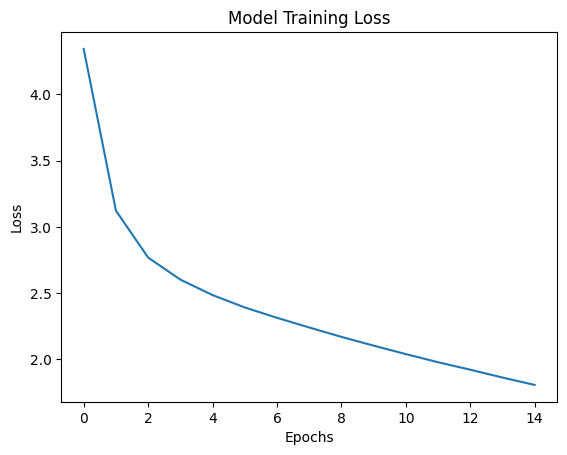

138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 1.8601
Evaluation Loss: 1.7605924606323242


In [68]:
model, history = train_model(model, encoder_input_data, decoder_input_data, decoder_output_data)

# Evaluate the model on test data
predictions, loss = evaluate_model(model, encoder_input_data, decoder_input_data, decoder_output_data)


# Step 6: Defining Inference Models

Encoder Inference Model: Takes questions as input and outputs LSTM states (h and c)

Decoder Inference Model: Takes in 2 inputs one are the LSTM states, second are the answer input sequences. it will o/p the answers for questions which fed to the encoder model and it's state values.

In [70]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    
    decoder_states = [state_h, state_c]

    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

# Step 7: Talking with the Chatbot

define a method str_to_tokens which converts str questions to Integer tokens with padding.

1. First, we take a question as input and predict the state values using enc_model.
2. We set the state values in the decoder's LSTM.
3. Then, we generate a sequence which contains the <start> element.
4. We input this sequence in the dec_model.
5. We replace the <start> element with the element which was predicted by the dec_model and update the state values.
6. We carry out the above steps iteratively till we hit the <end> tag or the maximum answer length.



In [71]:
def str_to_tokens( sentence : str ):

    words = sentence.lower().split()
    tokens_list = list()
  
    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')


In [73]:
enc_model, dec_model = make_inference_models()

for _ in range(10):
    # Get the initial state of the encoder
    states_values = enc_model.predict(str_to_tokens(input('Enter question : ')))
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer.word_index.get('start', 0)  # Ensure 'start' token exists
    stop_condition = False
    decoded_translation = ''
    word_len = 0 
    while not stop_condition or word_len == 10:
        word_len = word_len + 1
        # Predict the next word and hidden states from the decoder
        dec_outputs, h, c = dec_model.predict([empty_target_seq] + states_values)
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        
        # Find the word corresponding to the sampled index
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                decoded_translation += ' {}'.format(word)
                sampled_word = word
                break  # Stop once the word is found
        
        # Print for debugging
        print(f"Sampled Word Index: {sampled_word_index}, Word: {sampled_word}")
        print(f"Decoded Translation so far: {decoded_translation}")
        
        # Check for stopping condition
        if sampled_word == 'end' or sampled_word == None or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True
        
        # Prepare the next target sequence for the decoder
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        states_values = [h, c]  # Update the states for the next step

    print(f"Decoded Translation: {decoded_translation}")


Enter question :  fat of cream cheese


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Sampled Word Index: 11, Word: fat
Decoded Translation so far:  fat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 26, Word: mcdonalds
Decoded Translation so far:  fat mcdonalds
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 3, Word: is
Decoded Translation so far:  fat mcdonalds is
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sampled Word Index: 7, Word: 0
Decoded Translation so far:  fat mcdonalds is 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sampled Word Index: 0, Word: None
Decoded Translation so far:  fat mcdonalds is 0
Decoded Translation:  fat mcdonalds is 0


Enter question :  light catupiry


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 18, Word: potassium
Decoded Translation so far:  potassium
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 1, Word: of
Decoded Translation so far:  potassium of
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 7, Word: 0
Decoded Translation so far:  potassium of 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 0, Word: None
Decoded Translation so far:  potassium of 0
Decoded Translation:  potassium of 0


Enter question :  sugars of ricotta cheese


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sampled Word Index: 1, Word: of
Decoded Translation so far:  of
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 10, Word: cheese
Decoded Translation so far:  of cheese
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 3, Word: is
Decoded Translation so far:  of cheese is
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 7, Word: 0
Decoded Translation so far:  of cheese is 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 0, Word: None
Decoded Translation so far:  of cheese is 0
Decoded Translation:  of cheese is 0


Enter question :  end


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sampled Word Index: 18, Word: potassium
Decoded Translation so far:  potassium
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sampled Word Index: 40, Word: king
Decoded Translation so far:  potassium king
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sampled Word Index: 8, Word: raw
Decoded Translation so far:  potassium king raw
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Sampled Word Index: 3, Word: is
Decoded Translation so far:  potassium king raw is
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Sampled Word Index: 36, Word: 9
Decoded Translation so far:  potassium king raw is 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sampled Word Index: 0, Word: None
Decoded Translation so far:  potassium king raw is 9
Decoded Translation:  potassium king raw is 9


Enter question :  exit


KeyError: 'exit'